In this example we will build a polynomial neural network based on Lie transform that represents a simple circular accelerator. Commonly such accelerators consist of sequence of control elements that affect on charged particles. The dynamics of particles can be described by systems of nonlinear ordinary differential equations. So one can describe it in terms of Lie tramsform.
<table border="0">
  <tr>
    <td><img src="data/accelerator/fig_7.jpg" width=300/></td>
    <td><img src="data/accelerator/fig_8.jpg" width=600/></td>
  </tr>
</table>

Let's consider that each particle is presented by a state vector consisting coordinates, energy, spin vector. We can simulate dynamics of a particle simply propogating it throw sequence of Lie map.

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')


from core.Lie import LieLayer

At the begining, we define a structure of our accelerator.

In [4]:
dim = 10  # predefined state vector dimension, contains physical parameters of a particle
order = 3 # predefined order of nonlinearity, order of Lie map

# we have 4 different control elements
# e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
DH = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
QFA= LieLayer(output_dim = dim, order = order, input_shape = (dim,))
QDA= LieLayer(output_dim = dim, order = order, input_shape = (dim,))
OQS= LieLayer(output_dim = dim, order = order, input_shape = (dim,))


# our circular accelerator (storage ring) consists of 36 control elements (magnets or lenses in physics)
lattice = [QDA, OQS, DH, OQS, QFA, OQS, DH, OQS, QDA, 
           QDA, OQS, DH, OQS, QFA, OQS, DH, OQS, QDA, 
           QDA, OQS, DH, OQS, QFA, OQS, DH, OQS, QDA,
           QDA, OQS, DH, OQS, QFA, OQS, DH, OQS, QDA]

# simply construct a neural network (computatuonal graph)
fodo = Sequential()
for el in lattice:
    fodo.add(el)

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:622: UserWarning: Class `core.Lie.LieLayer` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


The weights of a Lie map define dynamics of the system. We will use precalculated weights matrices as an example.

In [6]:
# some utility code for precalculated matrices loading
def getPhaseStateVector(dim):
    state = []
    for i in xrange(dim):
        state.append(sp.Symbol('x%s'% str(i+1).zfill(2)))
    return sp.Array(state)


def load_Lie_map(state, filepath):
    print('load weights: ', filepath)
    state_power = np.array([1])
    order = 0

    weights = []
    W = []
    with open(filepath, 'r') as file:
        for row in file:
            row = row.replace('\r', '')
            row = row.replace('\n', '')

            if(0==len(row)):
                W = np.array(W)
                W_ext = np.zeros((len(state), len(state_power)))
                str_power = state_power.astype(str)
                reduced_str_power = []
                sl = []
                for i, el in enumerate(str_power):
                    if el not in reduced_str_power:
                        reduced_str_power.append(el)
                        sl.append(i)
                
                W_ext[:, sl] = W
                weights.append(W_ext.T)
                state_power = np.kron(state_power, state)
                W = []
                continue

            if row[0] != '%':
                row = map(float, row.split(' '))
                W.append(row)
    return weights

Let's now load txt files with weights into layers

In [9]:
state = getPhaseStateVector(dim=dim)
print(state)
# e.g. x01 means radial coordinate, and x04 its momentum, (x07, x08, x09) define spin vector
# x10 equals to length along reference orbit (center circular curve of a ring)
DH.set_weights(load_Lie_map(state, filepath='data/accelerator/DH.txt'  ))
QFA.set_weights(load_Lie_map(state, filepath='data/accelerator/QFA.txt'))
QDA.set_weights(load_Lie_map(state, filepath='data/accelerator/QDA.txt'))
OQS.set_weights(load_Lie_map(state, filepath='data/accelerator/OQS.txt'))

[x01, x02, x03, x04, x05, x06, x07, x08, x09, x10]
('load weights: ', 'data/accelerator/DH.txt')
('load weights: ', 'data/accelerator/QFA.txt')
('load weights: ', 'data/accelerator/QDA.txt')
('load weights: ', 'data/accelerator/OQS.txt')


Now we have a polynomial neural network, that describes our accelerator. One can run simulation tasks and investigate some dynamics of particles. For instance, we can check stability of motion, or spin oscillations

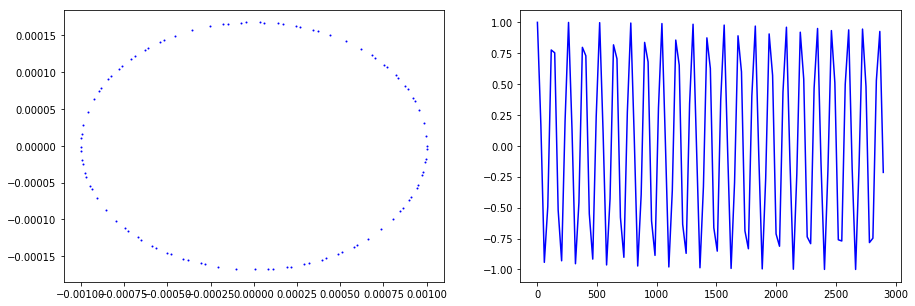

In [16]:
X0 = np.array([0.001,0,0,0,0,0,0,0,1,0]).reshape((-1, 10))
X = []
X.append(X0)
for i in xrange(100): # simulate 100 turns in storage ring
    X.append(fodo.predict(X[-1])) 
X = np.array(X)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(X[:, 0, 0], X[:, 0, 3], 'b.', markersize = 2) # motion in radial phase space
ax[1].plot(X[:, 0, -1], X[:, 0, 8], 'b-', markersize = 2)# spin oscillations
plt.show()